In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False
1,2025020461,2025-12-09T00:30:00,Toronto Maple Leafs,Tampa Bay Lightning,0.3402,0.4941,0.5672,2,0,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          457      0.5230 0.2558   0.7051 0.5117   0.5186
Totals (Over/Under)  457      0.4748 0.2500   0.6931 0.5116   0.5208
Asian Handicap       457      0.7462 0.1938   0.5781 0.5189   0.7440


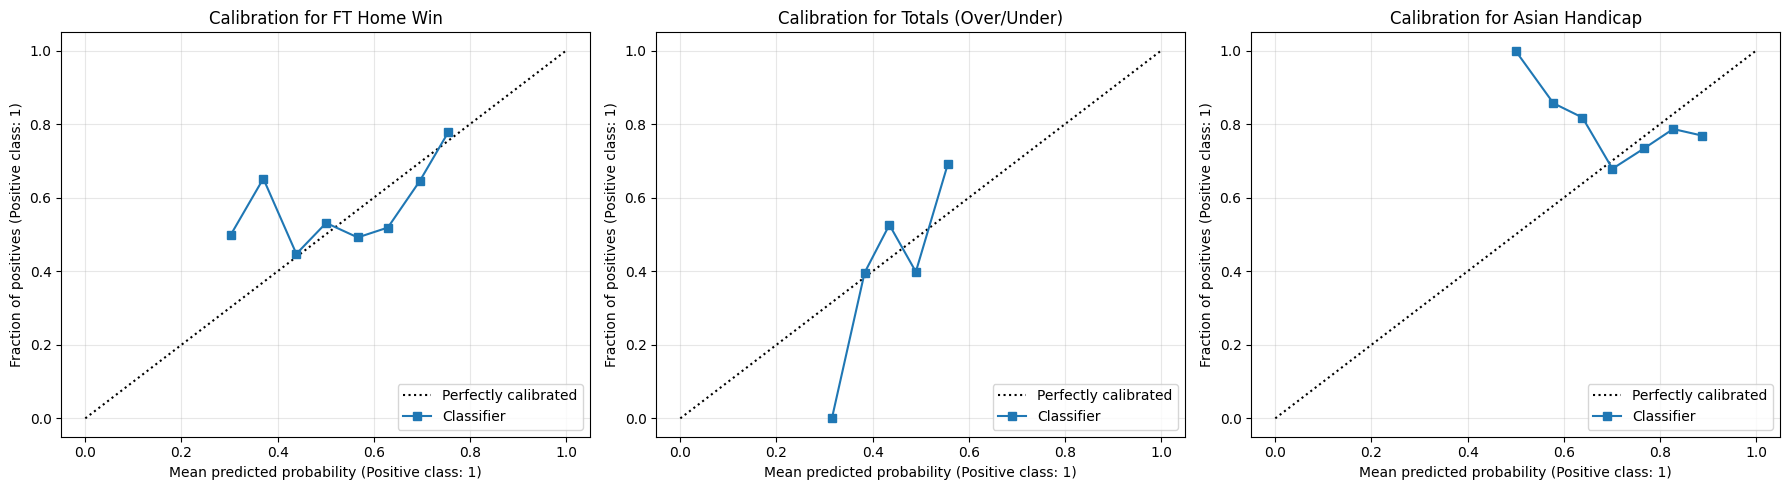

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          317      0.5205 0.2538   0.7004 0.5256   0.5174
Totals (Over/Under)  317      0.4763 0.2498   0.6927 0.5160   0.5047
Asian Handicap       317      0.7413 0.1980   0.5865 0.5058   0.7382


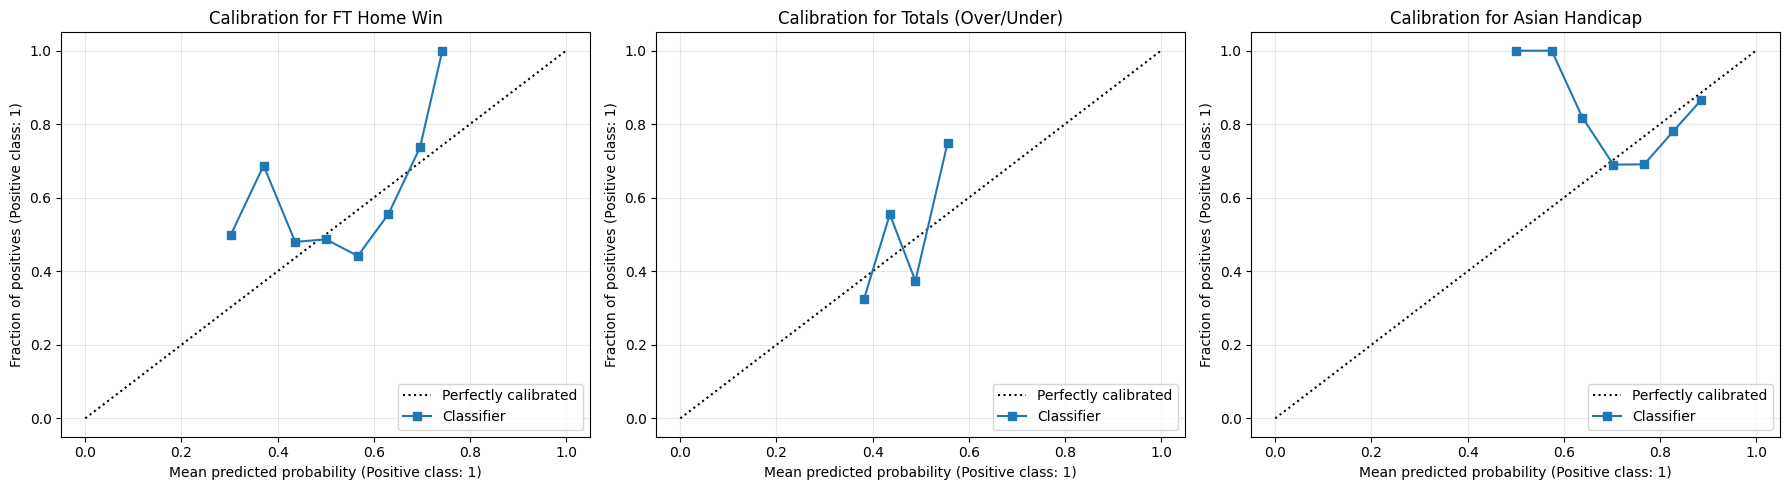

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500338,2025-12-06T00:00:00,Boston Celtics,Los Angeles Lakers,0.8098,0.7417,0.9232,126,105,True,True,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          166      0.5361 0.2168   0.6215 0.7081   0.6325
Totals (Over/Under)  166      0.5904 0.2547   0.7120 0.6135   0.5843
Asian Handicap       166      0.7289 0.1687   0.5031 0.7421   0.7470


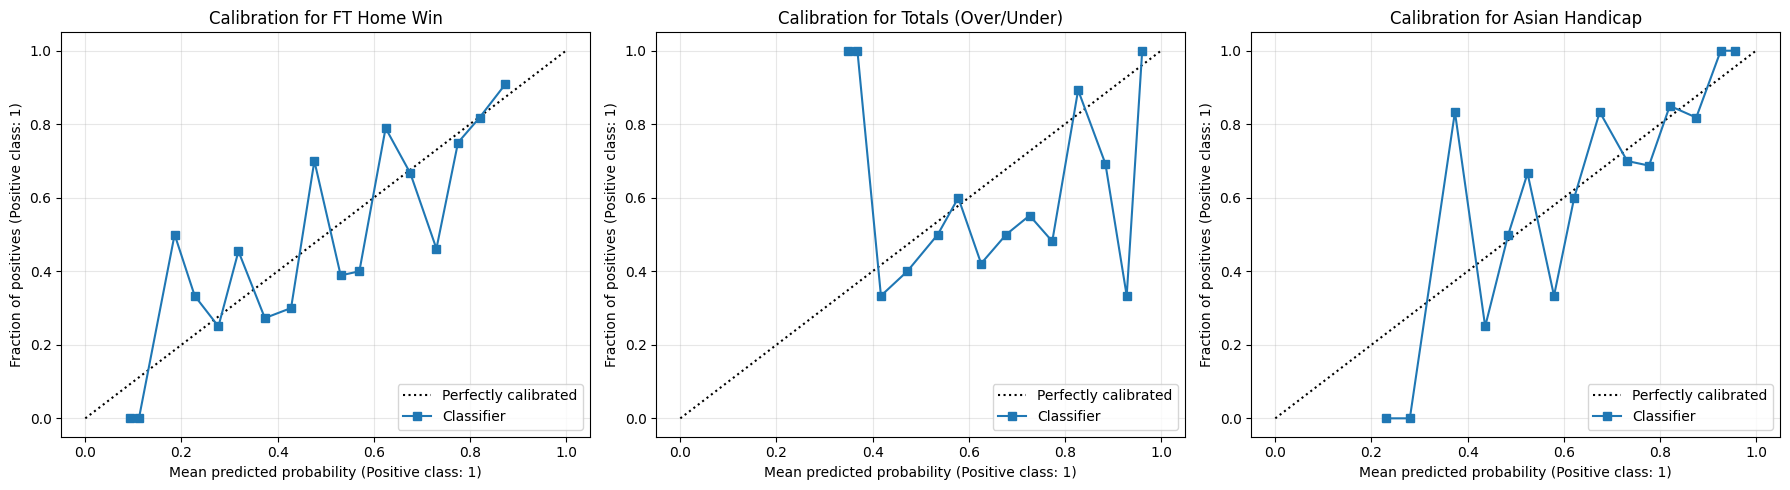

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)